# <span style="color:blue">  Movie Tweetings PySpark Recommender</span>


From the November 27th tweetings avaliable, the ratings and items data files will be loaded first into pandas and then converted to Spark dataframes. Both versions will be used for analysis and visualization purposes. 



In [1]:
import findspark
findspark.init('/usr/local/opt/apache-spark/libexec')
from pyspark import SparkContext
import pyspark
import pandas as pd

sc = pyspark.SparkContext(appName="spark based notebook")
#print sc


In [2]:
pdmovies = pd.read_csv('movies.dat', sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
pdmovies = pdmovies.drop('Genres', 1)
pdmovies[['movie', 'year']] = pdmovies['Movie_Title'].str.split('(',expand=True)
pdmovies[['year', 'del']] = pdmovies['year'].str.split(')',expand=True)
pdmovies = pdmovies.drop('del', 1)
pdmovies = pdmovies.drop('Movie_Title', 1)
pdratings = pd.read_csv('ratings.dat', sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
pdratings=pdratings.drop('Timestamp',1)

/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [3]:
import numpy as np
pdratings=pdratings.merge(pdmovies,on='MovieId',how='left')
pdratings["scaled"] = np.sign(pdratings.Rating - 5)
#print(pdratings)

The pandas dataframes are now converted to Spark dataframes using SQL Context.

In [4]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
ratings=sqlCtx.createDataFrame(pdratings)


# Exploratory Analysis & Visualization of Data

A statistical summary of the ratings data is provided below.

In [5]:
ratings.describe().show()

+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|summary|            UserId|           MovieId|           Rating|    movie|              year|            scaled|
+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|  count|            661041|            661041|           661041|   661041|            661041|            661041|
|   mean|25746.769123246515|1682644.1942859823|7.301606103101018| Infinity|2008.3000766972093|0.7817381977819833|
| stddev|14790.731994397118| 1261723.933614962|1.861220224723241|      NaN|12.648961199287482|0.5618353337379685|
|    min|                 1|                 8|                0|       $ |              1878|                -1|
|    max|             51713|           7659376|               10|Ãrestir |              2017|                 1|
+-------+------------------+------------------+-----------------+---------+-------------

In [6]:


print "Number of different users: " + str(ratings.select('userId').distinct().count())
print "Number of different movies: " + str(ratings.select('movieId').distinct().count())
print "Number of movies with at least one rating strictly less than 5: " + str(ratings.filter('rating < 5').select('movieId').distinct().count())
print "Number of movies with at least one rating 5 or greater : " + str(ratings.filter('rating >= 5').select('movieId').distinct().count())



Number of different users: 51713
Number of different movies: 29733
Number of movies with at least one rating strictly less than 5: 10230
Number of movies with at least one rating 5 or greater : 27234


In particular, we lack here a substantial number of ratings for items that are disliked by our users. This intuitively makes sense. Users may prefer to share their movie rating through Twitter if they enjoyed watching the film to allow their followers to know about a great movie. 


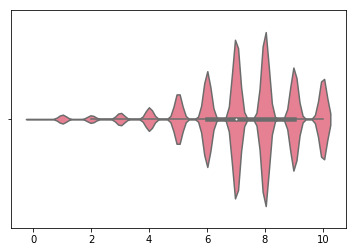

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.violinplot([pdratings.Rating],palette="husl")

We see here again that users tend to tweet structured tweets about movies they rate highly with 8 being the most common rating followed by 7. The sum of frequencies ofratings from 0 to 5 is approximately the frequeency of the rating 8.

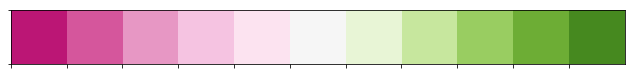

In [8]:
sns.palplot(sns.color_palette("PiYG", 11))


The diverging color palette above will be used in the following visualization to show movie ratings in a graph of movieid versus userid.

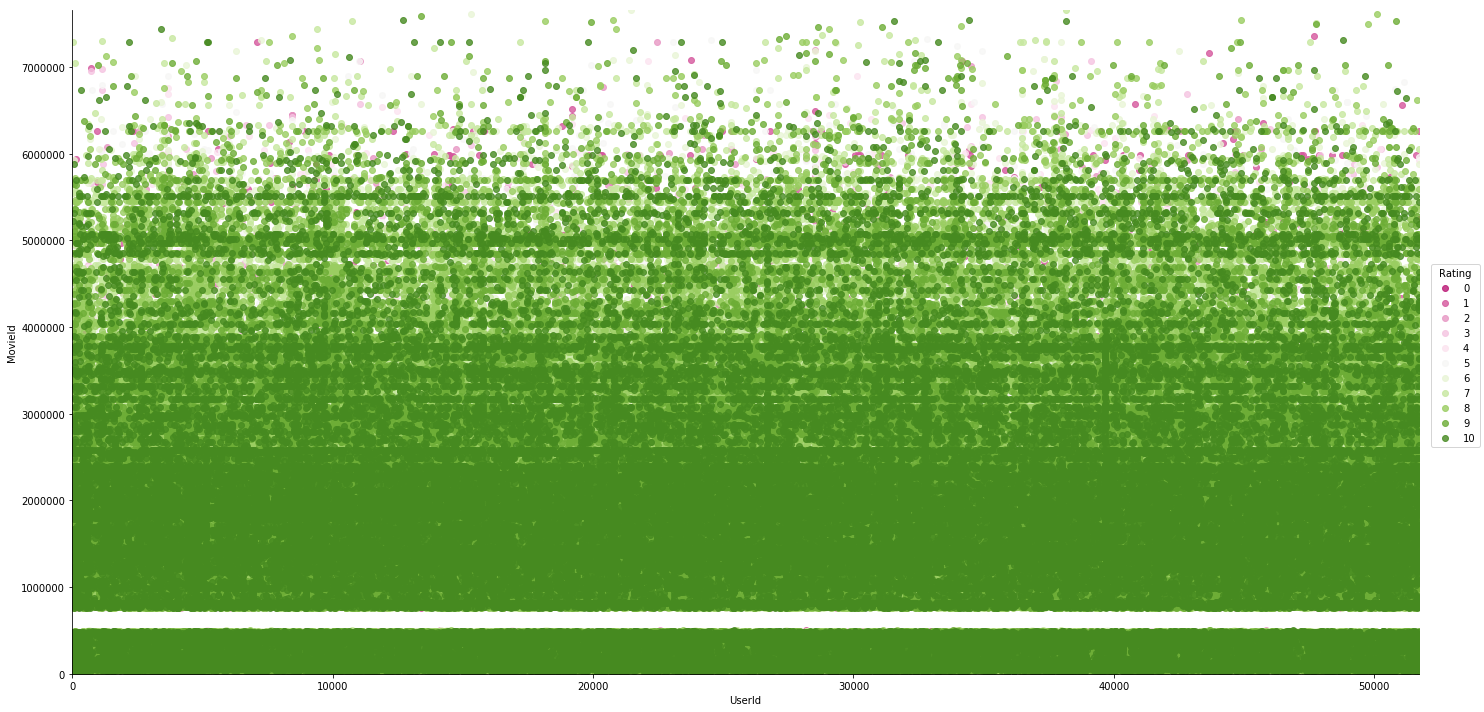

In [9]:


visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=pdratings, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

In [10]:
#pdratings.sort_values(by=['MovieId'],ascending=False)

Two key takeaways can be made about the graph above. First, we see the same pattern of a a greater frequency of highly rated movies. This graph is highly saturated with green more than pink. The new takeaway, however, is that there is a sparse amount of ratings for movies that have higher MovieIds which correspond to new movies. This in turn may lead to issues regarding accuracy when predicting new movies. 

# <span style="color:#3498db">  Implicit Feedback Model v Explicit Ratings Model</span>

Assuming that the asymmetric nature of the ratings distribution arises because of an analog of voluntary response bias, or rather in this case voluntary tweet bias, we can test the ALS model when ratings are considered as an explicit rating versus whether this provides implicit feedback representing strength of opinion. 

# Implicit Feedback Model

The data is initially split into 90% training data and 10% test data. The cold start problem here is addressed with dropping NaN values. Further, the ratings are taken as feedback of strength as opposed to explicit ratings.

In [11]:
from pyspark.ml.recommendation import ALS
(trainingRatings, testRatings) = ratings.randomSplit([90.0, 10.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating",implicitPrefs=True,coldStartStrategy="drop")

ALSimplmodel = als.fit(trainingRatings)

In [12]:
imppredictions = ALSimplmodel.transform(testRatings)
imppredictions.show()

+------+-------+------+--------------------+----+------+------------+
|UserId|MovieId|Rating|               movie|year|scaled|  prediction|
+------+-------+------+--------------------+----+------+------------+
| 50571|  33717|    10|        High Sierra |1941|     1| 0.035000578|
| 21054|  46521|     7|        I vitelloni |1953|     1|  0.19283096|
| 32782|  48254|     7|      Killer's Kiss |1955|     1| 0.039412793|
| 46213|  70355|     6|       Magnum Force |1973|     1| 0.037538912|
| 11185|  74281|     7|           Car Wash |1976|     1|0.0018904947|
| 51455|  92644|     6|Beverly Hills Cop...|1987|     1| 0.069455385|
| 26732|  92644|     7|Beverly Hills Cop...|1987|     1|  0.08975209|
| 41652|  92644|    10|Beverly Hills Cop...|1987|     1|   0.1410788|
| 25888|  92644|     6|Beverly Hills Cop...|1987|     1|  0.12094831|
|  5627|  92644|     7|Beverly Hills Cop...|1987|     1|  0.05808889|
| 18164|  92644|     6|Beverly Hills Cop...|1987|     1|  0.15370551|
| 25500|  92644|    

In [13]:
imp=imppredictions.toPandas()
imp=imp.sort_values(by=['UserId', 'prediction'],ascending=False)

In [14]:
implicit_by_pred=imp.groupby('UserId').head(3).reset_index(drop=True)

In [15]:
test=testRatings.toPandas()
#test=test.sort_values(by=['UserId', 'Rating'],ascending=False)
#test=test.groupby('UserId').head(3).reset_index(drop=True)

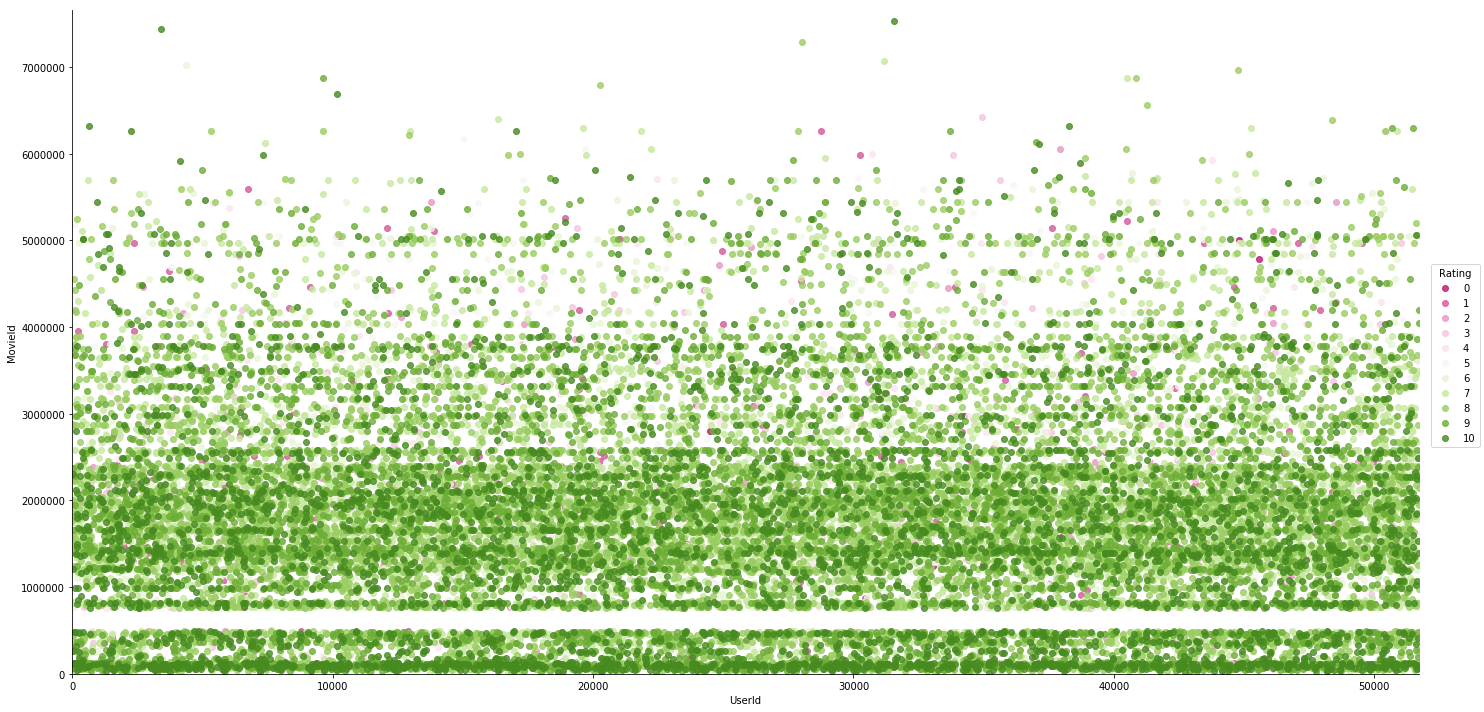

In [16]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=implicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

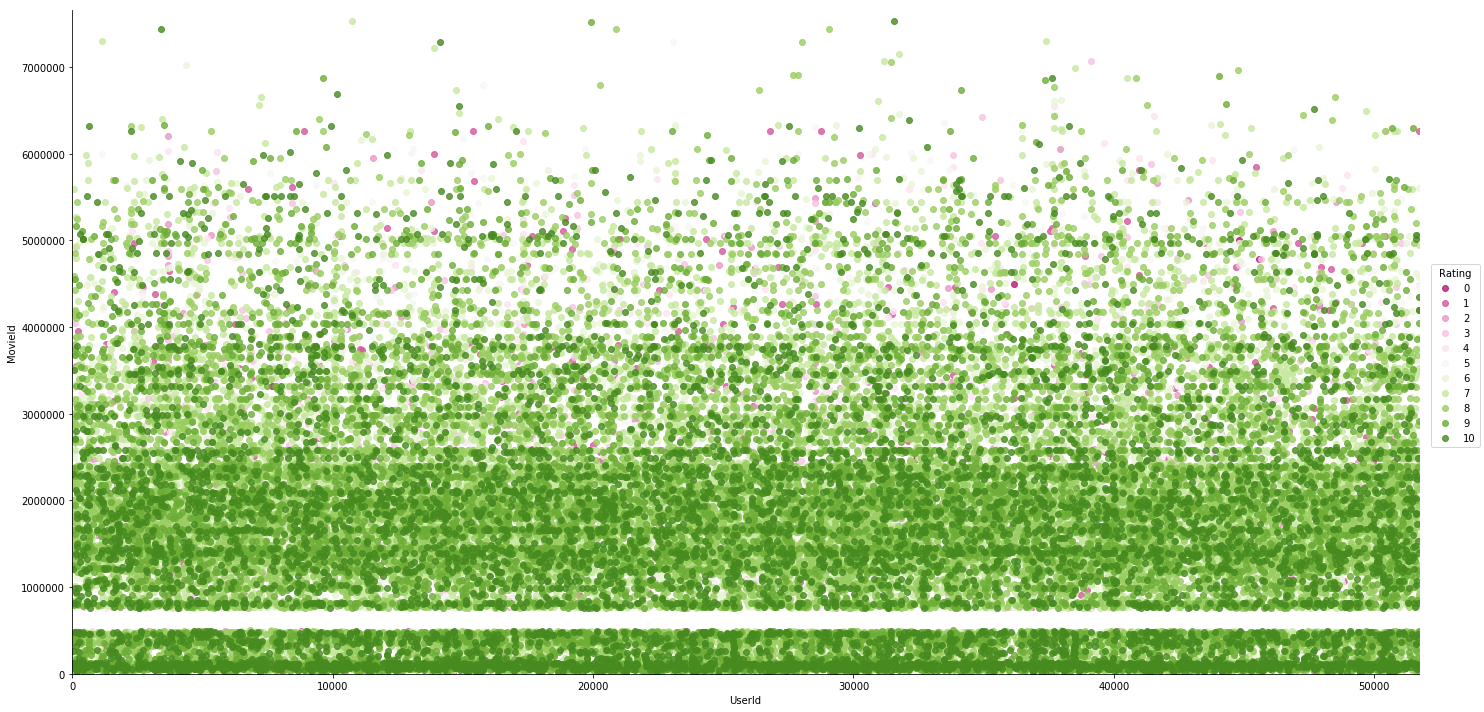

In [17]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='Rating', data=test, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

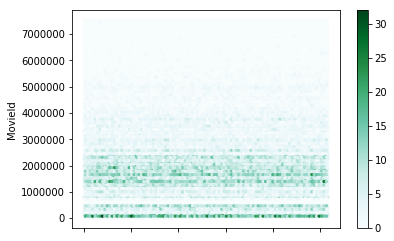

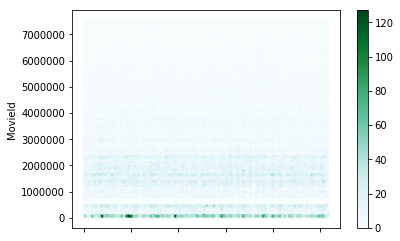

In [18]:
import pylab as plt

#plt.scatter(UserId,MovieId,data=implicit_by_rating,color='k')
#plt.scatter(X,Y2,color='g')
#plt.show()

implicit_by_pred.plot(kind='hexbin', x='UserId', y='MovieId')
test.plot(kind='hexbin', x='UserId', y='MovieId')

The graphs above show that this implicit feedback model has given prediction values that correspond to the true top k=3 movies that individuals have rated and subsequently tweeted about. Spark does not have a metric calculator for precision and recall for such a model. As such we can qualitatively assess the visualizations above. We see that the model does not capture higher MovieIds or new movies that have ratings in the test data set. The model does however capture a bulk of the movies that have a high frequency of ratings.

Futher, we will consider the metric of the percentage of missing top 3 ratings from the test data set from the predicted set. This can be extended to capture the idea of how many of the relevant movies are captured by the model--recall.

We will first see how many of these top 3 ratings are missing in the predicted set of top 3 movies and then calculate a metric based on the total number ratings in the union of the test and predicted set.

In [19]:
implicit_by_pred=implicit_by_pred.drop('prediction',1)


In [20]:
missing=test[~test.isin(implicit_by_pred)].count()
missing

UserId     65998
MovieId    65976
Rating     61039
movie      65976
year       62703
scaled     43000
dtype: int64

In [21]:
total=implicit_by_pred.append(test).count()
total

UserId     96165
MovieId    96165
Rating     96165
movie      96165
year       96165
scaled     96165
dtype: int64

In [22]:
((missing)/total)[0]

0.68629958924764722

We therefore see that there is approximately 30% recall which is not a strong recall. Therefore we will explore the explicit ratings model.

# Explicit Ratings Model

The data is initially split into 90% training data and 10% test data. The ratings are taken as explicit ratings in this model implementation of ALS.

In [23]:
(trainingRatings, testRatings) = ratings.randomSplit([90.0, 10.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating")
ALSmodel = als.fit(trainingRatings)

In [24]:
predictions = ALSmodel.transform(testRatings)
predictions.show()

+------+-------+------+--------------------+----+------+----------+
|UserId|MovieId|Rating|               movie|year|scaled|prediction|
+------+-------+------+--------------------+----+------+----------+
|  9574|  18051|     9|    The Kid Brother |1927|     1|  5.963533|
| 38855|  33717|     5|        High Sierra |1941|     0| 7.4930816|
| 32782|  48254|     7|      Killer's Kiss |1955|     1|  7.294066|
| 15728|  48254|     9|      Killer's Kiss |1955|     1| 7.0327063|
| 41027|  70355|     7|       Magnum Force |1973|     1|   7.10324|
| 41151|  72820|     7|        Cooley High |1975|     1|  4.909725|
| 35679|  92644|     6|Beverly Hills Cop...|1987|     1| 5.9950333|
| 51525|  92644|     7|Beverly Hills Cop...|1987|     1|  8.360492|
| 23253|  95715|    10|      Neco z Alenky |1988|     1|  9.034098|
|  3675|  99817|     4|         Dark Angel |1990|    -1|  6.257517|
|  9062|  99817|     8|         Dark Angel |1990|     1|   9.28252|
| 44259| 101775|    10|     Drop Dead Fred |1991

In [25]:
exp=predictions.toPandas()
exp=exp.sort_values(by=['UserId', 'prediction'],ascending=False)
explicit_by_pred=exp.groupby('UserId').head(3).reset_index(drop=True)

In [26]:
exp=exp.sort_values(by=['UserId', 'Rating'],ascending=False)
explicit_by_rating=exp.groupby('UserId').head(3).reset_index(drop=True)

(0, 51713)

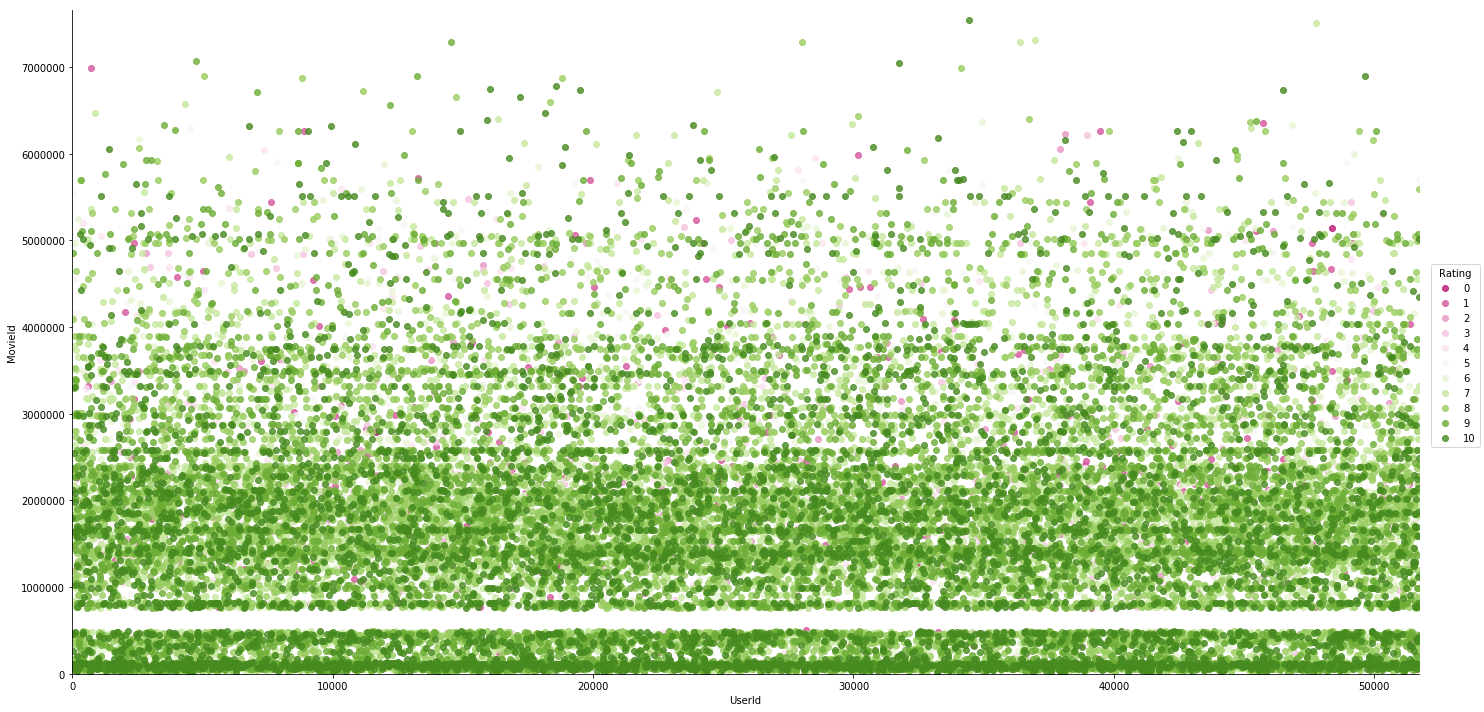

In [27]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=explicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
#visualize

(0, 51713)

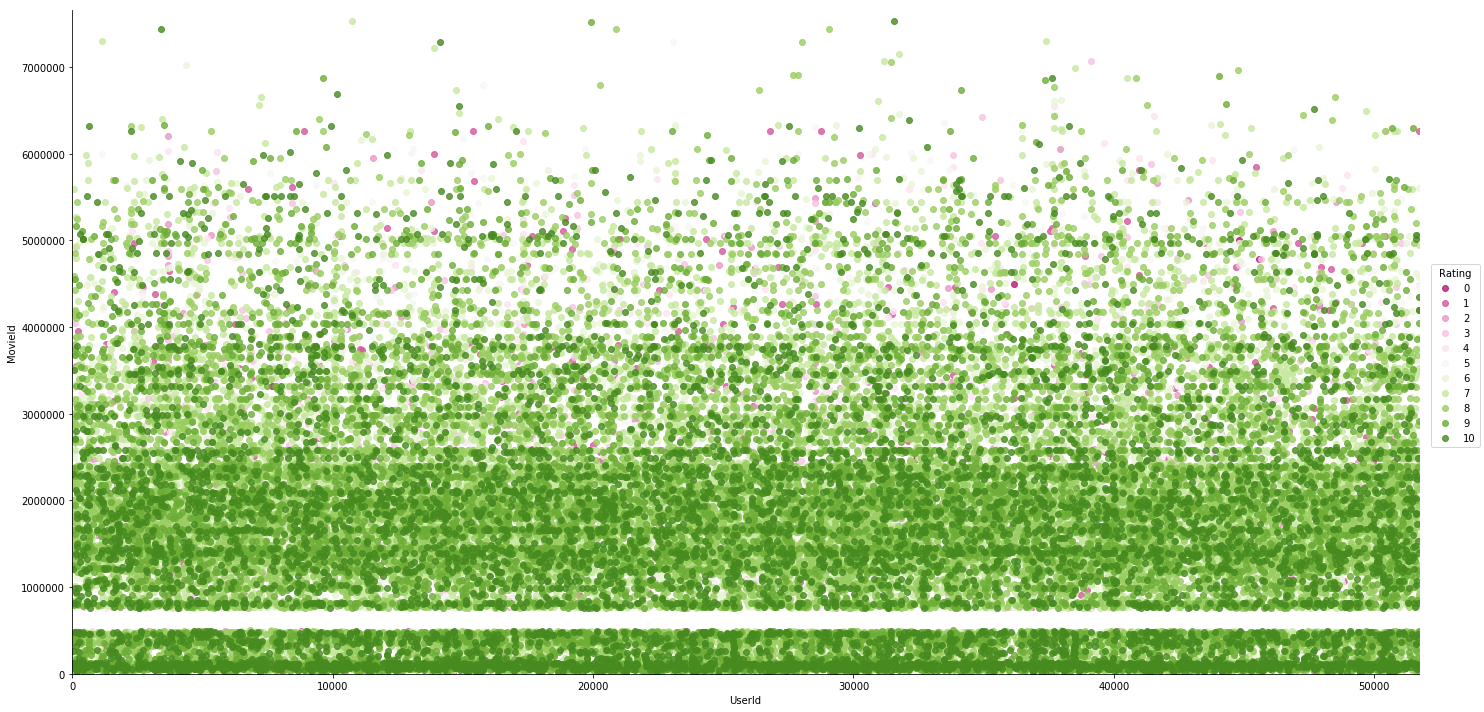

In [28]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='Rating', data=test, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
#visualize

Again, we notice a degree of sparsity of ratings for newer movies. However, in the case of the explicit ratings model, we can calculate a traditional accuracy metric.
Now we will compare the model with a naive baseline that always returns the mean rating through RMSE.

In [29]:
test=testRatings.toPandas()
test['mean'] = test["Rating"].mean()
test['difference']=(test['Rating']-test['mean'])
test['difference']=test['difference']**2


In [30]:
baselinermse=test["difference"].mean()**.5
baselinermse

1.8669040860833637

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions))

The root mean squared error for the model is: nan


NaN results because the ALS model cannot predict ratings for users who have no ratings which is also known as the Cold Start problem. In this business case scenario we would still wish to predict recommendations for that user. Therefore, we elect to replace NaN values with the average rating and evaluate the model.

In [32]:
average = ratings.select('rating').groupBy().avg().first()[0]
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
testRMSE=(evaluator.evaluate(predictions.na.fill(average))) 
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions.na.fill(average))) 


The root mean squared error for the model is: 1.67128043515


In [33]:
improvement = (baselinermse - testRMSE) / baselinermse * 100
improvement

10.47850569228057

There is a >10% improvement over the naive model that rates every movie the average of movie ratings.  

# Tuning Hyperparamters for Explicit Ratings Model: Rank & the Regularization Parameter

The following hyperparamter modeling is computationally costly. A grid of parameter combinations is created a grid search is run over these respective combinations to compare their performance. The resulting model has an RMSE that is greater than the model above. 
Note: Because this is computationally costly, it may take several minutes to run.

In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = ratings.randomSplit([90.0, 10.0])
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [5, 10])\
            .addGrid(als.maxIter, [10])\
            .addGrid(als.regParam, [.01,0.05, 0.1, 0.5])\
            .build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(average)))

The root mean squared error for our model is: 2.15142591872


The RMSE here is greater than that of the default ALS model: rank=10, maxIter=10, regParam=0.1. 

# Model Extension: Recommending New Movies

Our business seeks to drive its revenue growth by partnering with cinemas and theaters and providing new movie recommendations. We want to extend the model and constrain the movies recommendations to those that have just hit the screens recently. We will therefore give the top recommendations for those movies that have been released within the last 2 years, capturing the market of theaters that stream movies for $2 that are between the box office and blu-ray avaliability as well as traditional theaters. For users where such a movie recommendation is not possible, we will recommend the most recent movies possible for them. 

The approach we undertake is essentially augmenting or constraining the explicit ratings model and only recommeding the top n=3 most recent movies. We will then check the perfomance of this model versus if we used a naive baseline that always returns the mean rating. Further we will compare it to the baseline obtained earlier to benchmark the augmentation's difference from model to model.

In [35]:
exp=exp.sort_values(by=['UserId', 'year', 'prediction'],ascending=False)


In [36]:
newmovies=exp.groupby('UserId').head(3).reset_index(drop=True)

In [37]:
newmovies['mean'] = newmovies["prediction"].mean()
newmovies['difference']=(newmovies['Rating']-newmovies['mean'])
newmovies['difference']=newmovies['difference']**2


In [38]:
newmoviesrmse=newmovies["difference"].mean()**.5
newmoviesrmse

1.9400548022749473

Now we will compare this to two naive models that will return the top 3 newest movies recommended for a user based on the mean rating as well as the model that returns top 3 movies regardless of year.

In [39]:
test=testRatings.toPandas()

In [40]:
test['mean'] = test["Rating"].mean()
test=test.sort_values(by=['UserId', 'year', 'mean'],ascending=False)
test=test.groupby('UserId').head(3).reset_index(drop=True)
test['difference']=(test['Rating']-test['mean'])
test['difference']=test['difference']**2


In [41]:
test['difference']=(newmovies['Rating']-newmovies['mean'])
test['difference']=newmovies['difference']**2


In [42]:
baselinermse2=test["difference"].mean()**.5
baselinermse2

6.9405799355015825

In [43]:
improvement = (baselinermse - newmoviesrmse) / baselinermse * 100
improvement

-3.918290004123823

In [44]:
improvement2 = (baselinermse2 - newmoviesrmse) / baselinermse2 * 100
improvement2

72.04765566705134

There is a roughly 3 fold improvement when predicting the top 3 new movies for a user with the explicit model versus the naive model in the parallel scope which only recommends new movies. Intutively this makes sense, because the naive model will simply recommend the newest movies where the explicit rating model will consider the user's previous ratings. 

There is a roughly 3% decrease in RMSE compared to the model that recommended all movies. However, in this scope, this 3% decrease is on average an error of .05 of rating prediction which is not going to reclassify the scaled rating from liked to disliked or vastly change the degree of predicted rating. 

In conclusion, we are comfortable with implementing this model after furthering tuning in Phase II before putting this code into implementation.